In [1]:

from sklearn import linear_model
from sklearn import svm
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
import seaborn as sns
import os
import matplotlib.cm as cm
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
from geopy.geocoders import Nominatim
import folium
from folium.features import DivIcon
from sklearn.feature_extraction.text import TfidfVectorizer
import missingno as msno
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx
from plotly.graph_objs import *
from os import path
from PIL import Image
from pandas import DataFrame, scatter_matrix
import warnings
warnings.filterwarnings("ignore")



%matplotlib inline
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w'


In [2]:
kLoans = pd.read_csv("kiva_loans.csv")
kIDs = pd.read_csv("loan_theme_ids.csv")
kThemes = pd.read_csv("loan_themes_by_region.csv")

In [3]:
kLoans2 = kLoans.copy()

In [4]:
kLoans2.loc[kLoans2.country_code.isnull(), 'country'].unique()

kLoans2['country_code'] = kLoans2['country_code'].fillna('NAM')

kLoans2['disbursed_time'] = kLoans2['disbursed_time'].fillna(kLoans2['posted_time'])
kLoans2['funded_time'] = kLoans2['funded_time'].fillna(kLoans2['posted_time'])

kLoans2['borrower_genders'] = kLoans2['borrower_genders'].fillna(method='pad')

kLoans2['log_amount'] = np.log(kLoans2['funded_amount'] + 1)

kLoans2['disbursed_time'] = pd.to_datetime(kLoans2['disbursed_time'])
kLoans2['date'] = pd.to_datetime(kLoans2['date'])
kLoans2['posted_time'] = pd.to_datetime(kLoans2['posted_time'])
kLoans2['funded_time'] = pd.to_datetime(kLoans2['funded_time'])

for i, row in kLoans2.iterrows():
    g = row['borrower_genders']         
    
    female = g.count('female')
    male = g.count('male')
    
    kLoans2.set_value(i, 'borrower_female', female)
    kLoans2.set_value(i, 'borrower_male', male)
    
kLoans2.borrower_male = kLoans2.borrower_male.astype(int)
kLoans2.borrower_female = kLoans2.borrower_female.astype(int)

In [5]:
kLoans2.head()

id  funded_amount  loan_amount             activity          sector  \
0  653051          300.0        300.0  Fruits & Vegetables            Food   
1  653053          575.0        575.0             Rickshaw  Transportation   
2  653068          150.0        150.0       Transportation  Transportation   
3  653063          200.0        200.0           Embroidery            Arts   
4  653084          400.0        400.0           Milk Sales            Food   

                                                 use country_code   country  \
0            To buy seasonal, fresh fruits to sell.            PK  Pakistan   
1  to repair and maintain the auto rickshaw used ...           PK  Pakistan   
2  To repair their old cycle-van and buy another ...           IN     India   
3  to purchase an embroidery machine and a variet...           PK  Pakistan   
4                           to purchase one buffalo.           PK  Pakistan   

         region currency      ...              funded_time term_in_months  \
0        Lahore      PKR      ...      2014-01-02 10:06:32           12.0   
1        Lahore      PKR      ...      2014-01-02 09:17:23           11.0   
2     Maynaguri      INR      ...      2014-01-01 16:01:36           43.0   
3        Lahore      PKR      ...      2014-01-01 13:00:00           11.0   
4  Abdul Hakeem      PKR      ...      2014-01-01 19:18:51           14.0   

  lender_count                          tags  borrower_genders  \
0           12                           NaN            female   
1           14                           NaN    female, female   
2            6  user_favorite, user_favorite            female   
3            8                           NaN            female   
4           16                           NaN            female   

   repayment_interval       date log_amount borrower_female borrower_male  
0           irregular 2014-01-01   5.707110               1             1  
1           irregular 2014-01-01   6.356108               2             2  
2              bullet 2014-01-01   5.017280               1             1  
3           irregular 2014-01-01   5.303305               1             1  
4             monthly 2014-01-01   5.993961               1             1  

[5 rows x 23 columns]

In [6]:
kDF = kLoans2.copy()
kDF = kDF.drop(labels=['id', 'use', 'tags', 'region', 'country_code', 'currency', 'partner_id', 'disbursed_time',
                               'funded_time', 'posted_time', 'borrower_genders', 'loan_amount'], axis=1)
kDF.columns = ['Amount', 'Activity', 'Sector', 'Country', 'Term', 'Lenders', 'Repayment_Interval', 'Date', 'Log_Amount',
                   'Females',  'Males']
kDF = kDF [['Country', 'Sector', 'Activity', 'Date', 'Repayment_Interval', 'Term', 'Amount', 'Log_Amount', 'Lenders',
                    'Females', 'Males']]

In [7]:
kDF.head()

Country          Sector             Activity       Date  \
0  Pakistan            Food  Fruits & Vegetables 2014-01-01   
1  Pakistan  Transportation             Rickshaw 2014-01-01   
2     India  Transportation       Transportation 2014-01-01   
3  Pakistan            Arts           Embroidery 2014-01-01   
4  Pakistan            Food           Milk Sales 2014-01-01   

  Repayment_Interval  Term  Amount  Log_Amount  Lenders  Females  Males  
0          irregular  12.0   300.0    5.707110       12        1      1  
1          irregular  11.0   575.0    6.356108       14        2      2  
2             bullet  43.0   150.0    5.017280        6        1      1  
3          irregular  11.0   200.0    5.303305        8        1      1  
4            monthly  14.0   400.0    5.993961       16        1      1

In [11]:
countries = kDF['Country'].value_counts().to_frame()
countries.reset_index(inplace=True)
countries = countries.rename(columns = {'index':'Country', 'Country':'NumberOfLoans'})

top20List = countries[:20].copy()

top20Geo = top20List.copy()
top20Geo = top20Geo.drop('NumberOfLoans', axis = 1)


colors = cm.YlGnBu(np.linspace(0,1,len(top20List)))



In [12]:
import plotly.graph_objs as go
import plotly.offline as py


cnt_s = kDF['Sector'].value_counts()

labels = cnt_s.index
values = cnt_s.values
trace = go.Pie(labels=labels, values=values)
py.iplot([trace], filename='basic_pie_chart')

In [15]:
cnt_s5 = cnt_s[:5]
sectors = ['Agriculture', 'Food', 'Retail', 'Services', 'Personal Use']
cnt_a2 = kDF.groupby(['Sector'])['Activity'].value_counts().groupby(level=0).head(3).reset_index(name='count')
cnt_a2 = cnt_a2.groupby(['Sector','Activity'], as_index=False)['count'].sum()
cnt_a2 = pd.DataFrame(cnt_a2)
cnt_a2 = cnt_a2.loc[cnt_a2['Sector'].isin(sectors)].reset_index(drop=True)

color_list = ['#D98880', '#D7DBDD', '#F4D03F', '#45B39D', '#9A7D0A', '#884EA0', '#34495E', '#EAF2F8',
              '#1F618D', '#76448A', '#99A3A4', '#27AE60', '#935116', '#85C1E9', '#6C3483']
#fig, ax = plt.subplots(figsize=(14,8))
cnt_p = cnt_a2.pivot_table(index="Activity", columns="Sector", values="count").T.fillna(0)
cnt_p.plot(kind='barh', ax=ax, color=color_list, stacked=True, legend=True).invert_yaxis()

ax.set_title("Top 3 Activities per Sector", fontsize=20)
ax.set_xlabel("Activities", fontsize=15)
ax.set_ylabel("Sectors", fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


labels = []
for j in cnt_p.columns:
    for i in cnt_p.index:
        label = str(j)
        if (label=="Fruits & Vegetables"):
            label = "Fruits&Vegetables"
        if (label=="Home Energy"):
            label = "Energy"
        if (label=="Personal Expenses"):
            label = "Personal"
        if (label=="Cosmetics Sales"):
            label = "C.Sales"
        labels.append(label)

                
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', fontsize="small")
#plt.legend(bbox_to_anchor=(1.2,1), fontsize=10)

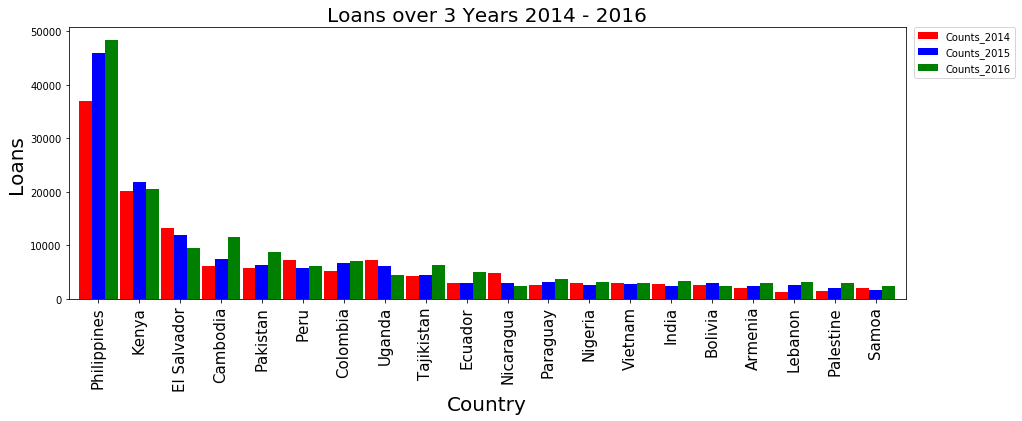

In [16]:
kivaTime = kDF.copy()
kivaTime['Year'] = kivaTime['Date'].dt.year
kivaTime = kivaTime[kivaTime.Year != 2017]

kivaGrowth = pd.DataFrame(kivaTime.groupby('Country').size()).reset_index().rename(columns={'Country': 'Country', 0: 'Count'}).sort_values(by = 'Count', ascending = False).reset_index(drop=True)
kivaTemp = pd.DataFrame(kivaTime.groupby(['Country', 'Year']).size()).reset_index().rename(columns={'Country': 'Country', 0: 'Count'}).sort_values(by = 'Count', ascending = False).reset_index(drop=True)

for i, row in kivaGrowth.iterrows():
    Counts_2014 = kivaTemp.loc[(kivaTemp.Country==row.Country) & (kivaTemp.Year == 2014)].Count
    Counts_2015 = kivaTemp.loc[(kivaTemp.Country==row.Country) & (kivaTemp.Year == 2015)].Count
    Counts_2016 = kivaTemp.loc[(kivaTemp.Country==row.Country) & (kivaTemp.Year == 2016)].Count
    Counts_2017 = kivaTemp.loc[(kivaTemp.Country==row.Country) & (kivaTemp.Year == 2017)].Count
    
    if (len(Counts_2014) == 0):
        kivaGrowth.set_value(i, 'Counts_2014', 0)
    else:
        kivaGrowth.set_value(i, 'Counts_2014', Counts_2014.item())
        
    if (len(Counts_2015) == 0):
        kivaGrowth.set_value(i, 'Counts_2015', 0)
    else:
        kivaGrowth.set_value(i, 'Counts_2015', Counts_2015.item())
        
    if (len(Counts_2016) == 0):
        kivaGrowth.set_value(i, 'Counts_2016', 0)
    else:
        kivaGrowth.set_value(i, 'Counts_2016', Counts_2016.item())
        
    if (len(Counts_2017) == 0):
        kivaGrowth.set_value(i, 'Counts_2017', 0)
    else:
        kivaGrowth.set_value(i, 'Counts_2017', Counts_2017.item())        

        
increase = kivaGrowth.loc[kivaGrowth.Counts_2016 > kivaGrowth.Counts_2014].Country.value_counts().sum()
decrease = kivaGrowth.loc[kivaGrowth.Counts_2016 < kivaGrowth.Counts_2014].Country.value_counts().sum()
same = kivaGrowth.loc[kivaGrowth.Counts_2016 == kivaGrowth.Counts_2014].Country.value_counts().sum()
total = kivaGrowth.Country.value_counts().sum()
inc_per = increase/total * 100
dec_per = decrease/total * 100

color_list = ['red', 'blue', 'green']
fig, ax = plt.subplots(figsize=(15,5))
kg = kivaGrowth[:20]

kg.plot(x="Country", y=["Counts_2014", "Counts_2015", "Counts_2016"], 
        kind="bar", ax = ax, width=0.95, color=color_list)
ax.set_title("Loans over 3 Years 2014 - 2016", fontsize=20)
ax.set_xlabel("Country", fontsize=20)
ax.set_ylabel("Loans", fontsize=20)
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize=15)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

In [17]:
cFundAmt = kLoans.groupby('country').mean()['funded_amount'].sort_values(ascending = False)

In [19]:
gdp = pd.read_excel("GDP.xlsx", 'Data', index_col=None)
income = pd.read_excel("Income_Classification.xlsx", 'Data', index_col=None)
gdpGrowth = pd.read_excel("GDP_growth.xlsx", 'Data', index_col=None)
lendRates = pd.read_csv("Bank Lending Rates.csv", 'Data', index_col=None, engine='python', delimiter=",")
humanDevIn = pd.read_excel("HDI_IHDI.xlsx", 'Data', index_col=None)

In [20]:
ibrd = pd.read_csv('IBRD_Loans.csv', 'Data', index_col=None, engine='python', delimiter=",")
inflation = pd.read_excel('Inflation.xls', 'Data', index_col=None)
gini = pd.read_excel('GINI Index.xls', 'Data', index_col=None)
sectors = pd.read_excel('By_Sector.xlsx', 'Data', index_col=None)
litFemale = pd.read_excel('Literacy_Rate_Female.xls', 'Data', index_col=None)
litMale = pd.read_excel('Literacy_Rate_Male.xls', 'Data', index_col=None)
popDensity = pd.read_excel('Population Density.xls', 'Data', index_col=None)
mpiC = pd.read_excel('MPI_National.xlsx', 'Data', index_col=None)
mpiR = pd.read_excel('MPI_Regional.xlsx', 'Data', index_col=None)



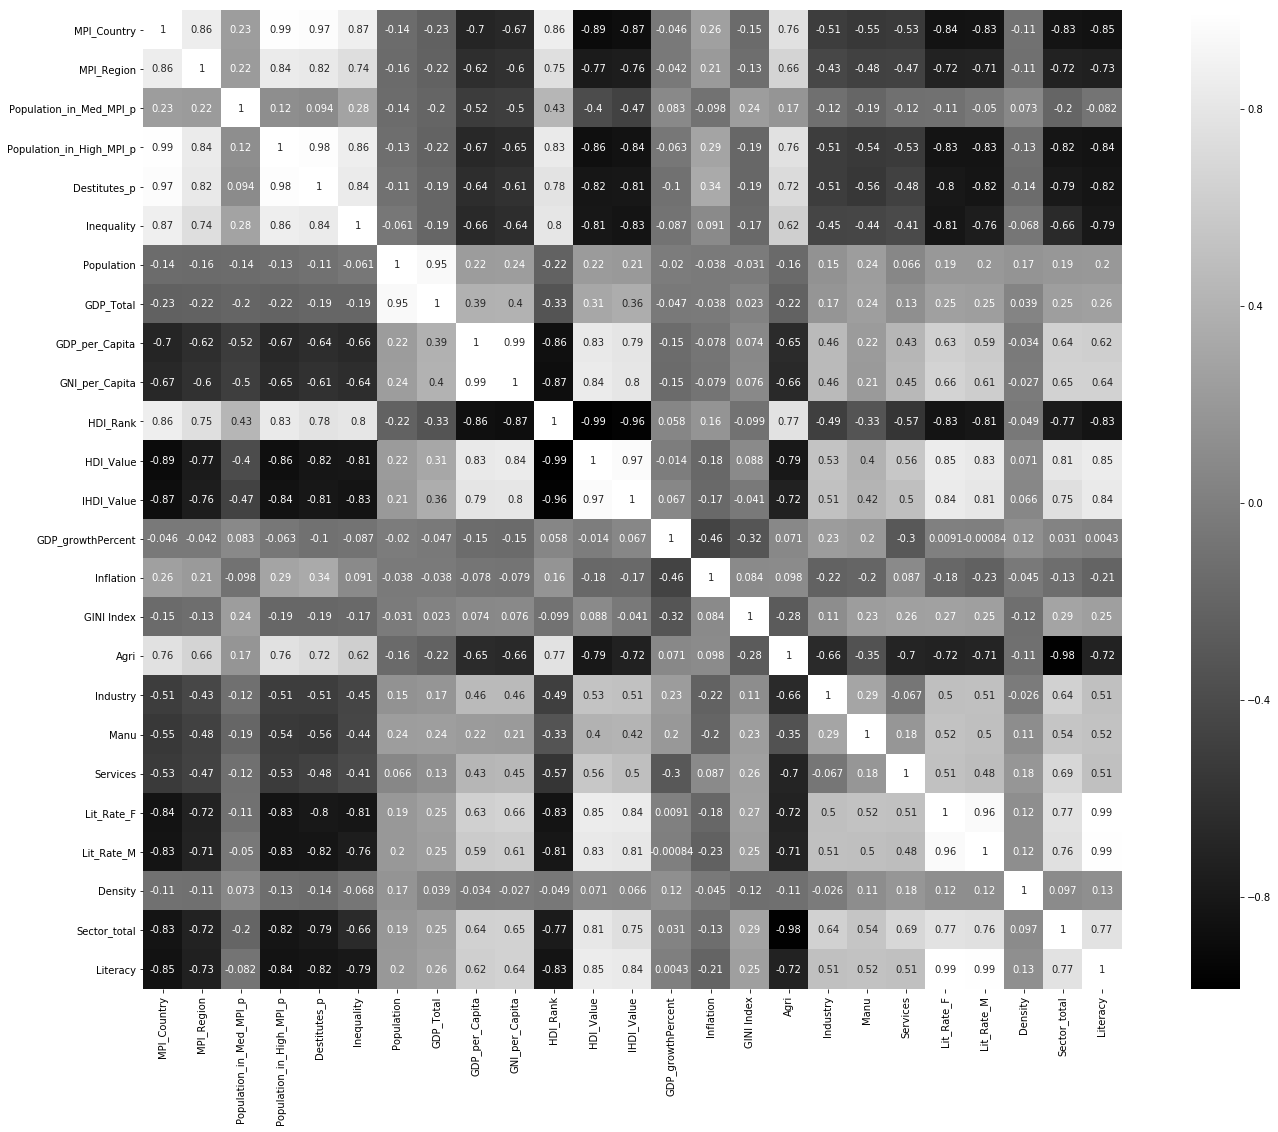

In [21]:
mpi1 = mpiR[['Country', 'Region','MPI_Region']].merge(mpiC, how="right", on = "Country")
mpi1 = mpi1[['Country_Code', 'World_Region', 'Country', 'Region', 'MPI_Country', 'MPI_Region', 'Population_in_Med_MPI_p', 'Population_in_High_MPI_p', 'Destitutes_p', 'Inequality', 'Population']]
mpi1['MPI_Region'] = mpi1['MPI_Region'].fillna(0)
mpi2 = mpi1.merge(countries[['Country']], how="outer", on = "Country")
mpi2 = mpi2.merge(gdp, how="left", on = "Country")
mpi2 = mpi2.merge(humanDevIn, how="left", on = "Country")
mpi2.loc[(mpi2.HDI_Scale=='Very High') & (mpi2['MPI_Country'].isnull()), 'MPI_Country'] = 0
mpi2.loc[(mpi2.HDI_Scale=='Very High') & (mpi2['MPI_Country'].isnull()), 'MPI_Region'] = 0
mpi2.loc[(mpi2.HDI_Scale=='High') & (mpi2['MPI_Country'].isnull()), 'MPI_Country'] = 0.001
mpi2.loc[(mpi2.HDI_Scale=='High') & (mpi2['MPI_Country'].isnull()), 'MPI_Region'] = 0.001
mpi3 = mpi2.copy()
mpi3 = mpi3.merge(gdpGrowth, how="left", on = "Country")
mpi3 = mpi3.merge(inflation, how="left", on = "Country")
mpi3 = mpi3.merge(gini, how="left", on = "Country")
mpi3 = mpi3.merge(sectors, how="left", on = "Country")
mpi3 = mpi3.merge(litFemale, how="left", on = "Country")
mpi3 = mpi3.merge(litMale, how="left", on = "Country")
mpi3 = mpi3.merge(popDensity, how="left", on = "Country")
mpi3 = mpi3.merge(income, how="left", on = "Country")

bins = [0,0.05,0.35,0.7]
group_names = ['Low','Medium','High']
mpi3["MPI_Category"] = pd.cut(mpi3["MPI_Country"], bins, labels=group_names)

mpi3["Sector_total"] = mpi3["Industry"] + mpi3["Manu"] + mpi3["Services"] - mpi3["Agri"]
mpi3["Literacy"] = (mpi3["Lit_Rate_F"] + mpi3["Lit_Rate_M"])/2

fig, ax = plt.subplots(figsize=(25,18))
c = mpi3.corr()
sns.heatmap(c, annot=True, ax=ax, square=True, cmap="binary_r")
plt.show()